# Practical task 
You will model the famous [Keeling curve](https://www.esrl.noaa.gov/gmd/ccgg/trends/) using contemporary deep learning frameworks. This notebook will download the data and read it in as numpy arrays and provide example code in [pytorch](https://pytorch.org/). You are welcome to use other frameworks and change the dataset to better fit your model arhitecture. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os 
%matplotlib inline
# %matplotlib notebook

from tqdm import tqdm

You can download the dataset from: ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt

or run the cell below which will check if the dataset is present in working directory and download it there if not.

In [2]:
url="ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt"
filename=os.path.split(url)[-1]

if not os.path.exists(filename):    
    from urllib import request
    print('Downloading data from:\n'+url)
    request.urlretrieve(url,filename)

Read in the data as `numpy` array

In [3]:
data=np.genfromtxt(filename,comments='#',missing_values='-99.99',usecols=[0,1,3])

Xfull=data[:,0]+(data[:,1]-1)/12.0
Yfull=data[:,-1]

missing_values=Yfull==-99.99

Yfull[missing_values] = None

Xfull = Xfull.reshape(-1, 1)
Yfull = Yfull.reshape(-1, 1)

# Interpolation
interp = np.interp(Xfull[missing_values],
                   Xfull[~missing_values].flatten(),
                   Yfull[~missing_values].flatten())
Yfull[missing_values] = interp

data=[]

# Use last 3 years as a test set 
test_length=3*12

Xtrain_np = Xfull[:-test_length]
Ytrain_np = Yfull[:-test_length]

Xtest_np = Xfull[-test_length:]
Ytest_np = Yfull[-test_length:]

# Data for prediction
Xpred_np = Xtrain_np[-1]+np.arange(1,40*12).reshape(-1,1)/12

Plot the train and test data

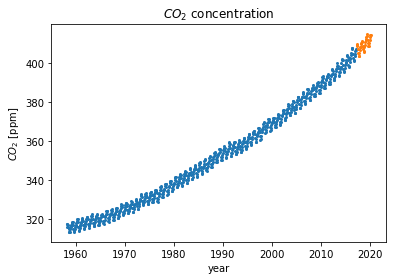

In [4]:
plt.scatter(Xtrain_np,Ytrain_np,marker='.',linewidths=0.05)
plt.scatter(Xtest_np,Ytest_np,marker='.',linewidths=0.05)
plt.title(r'$CO_2$ concentration')
plt.xlabel('year')
plt.ylabel(r'$CO_2$ [ppm]')
plt.show()

# Preprocess the data
You are allowed to change the preprocessing and structure of the dataset to better suit your model architecture.

Below is a simple example.

In [5]:
xshift=np.mean(Xtrain_np)
yshift=np.mean(Ytrain_np)

xscale=np.std(Xtrain_np)
yscale=np.std(Ytrain_np)


Xtrain_np-=xshift
Xtrain_np/=xscale
Ytrain_np-=yshift
Ytrain_np/=yscale

Xtest_np-=xshift
Xtest_np/=xscale
Ytest_np-=yshift
Ytest_np/=yscale


Xpred_np-=xshift
Xpred_np/=xscale

# Task:
Use a deep learning framwework of your choice to build and train a model to predict the CO$_2$ concentration up until year 2060.
Below is a Pytorch example with 2 ways to construct a model that you can use as a starting point. 

See the [nn module](https://pytorch.org/docs/stable/nn.html#) of Pytorch for inspiration on models and modules.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# if torch.cuda.is_available():  
#     device = torch.device("cuda:0") 
# else:  
#     device = torch.device("cpu")

device = torch.device("cpu")
print(device)

# Load the data into pytorch tensors for training
Xtrain=torch.FloatTensor(Xtrain_np).to(device)
Ytrain=torch.FloatTensor(Ytrain_np).to(device)

Xtest=torch.FloatTensor(Xtest_np).to(device)
Ytest=torch.FloatTensor(Ytest_np).to(device)

Xpred=torch.FloatTensor(Xpred_np).to(device)

cpu


## 2 layer DNN

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(1,128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.fc4(x)
        return x

    
    
model = Net()
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-4)
epochs = 400
for i in range(epochs):
    optimizer.zero_grad()
    y = model(Xtrain)
    loss = criterion(y, Ytrain)
    loss.backward()
    optimizer.step()
    if i % 50 == 0:
        with torch.no_grad():
            test_loss = criterion(model(Xtest), Ytest)
            print(f" {i}: {loss.item()}, {test_loss.item()}")

 0: 1.069217324256897, 3.7757492065429688
 50: 0.00925795640796423, 0.030889132991433144
 100: 0.006832053419202566, 0.008907289244234562
 150: 0.006657712161540985, 0.009192648343741894
 200: 0.0065789115615189075, 0.008991817943751812
 250: 0.006537153851240873, 0.008883519098162651
 300: 0.006520561873912811, 0.008869319222867489
 350: 0.006508958991616964, 0.008910760283470154


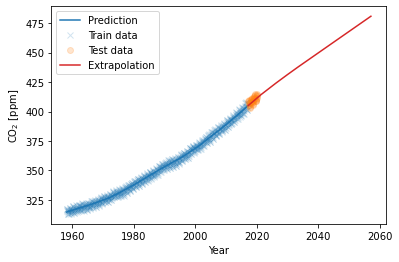

In [14]:
Xpred=torch.FloatTensor(Xpred_np).to(device)
with torch.no_grad():
    pred=model(Xtrain)
    predf=model(Xpred)
    
plt.plot(Xtrain.cpu().numpy()*xscale+xshift,pred.cpu().numpy()*yscale+yshift,color='C0',label='Prediction')
plt.plot(Xtrain_np*xscale+xshift,Ytrain_np*yscale+yshift,'x',color='C0',alpha=0.2,label='Train data')
plt.plot(Xtest_np*xscale+xshift,Ytest_np*yscale+yshift,'o',color='C1',alpha=0.2,label='Test data')
plt.plot(Xpred.cpu().numpy()*xscale+xshift,predf.cpu().numpy()*yscale+yshift,color='C3',label='Extrapolation')
plt.legend()
plt.xlabel(r'Year')
plt.ylabel(r'CO$_2$ [ppm]')
plt.show()

## Echo State Networks

### `pyESN`

In [8]:
if "pyESN" not in os.listdir():
    !git clone https://github.com/cknd/pyESN
        
from pyESN.pyESN import ESN

Cloning into 'pyESN'...
remote: Enumerating objects: 106, done.
remote: Total 106 (delta 0), reused 0 (delta 0), pack-reused 106
Receiving objects: 100% (106/106), 1.17 MiB | 1.16 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [9]:
best_model = None
best_error = np.inf
num_trials = 15

models = []

for n_res in tqdm(range(3, 30, 2)):  # number of neurons in the "reservoir"
    for sr in np.arange(0.5, 1.3, 0.1):  # spectral radius
        for i in range(num_trials):
            esn = ESN(
                n_inputs=1,
                n_reservoir=n_res,
                n_outputs=1,
                spectral_radius=sr
            )
    
            _ = esn.fit(Xtrain, Ytrain)
    
            Ytest_pred = esn.predict(torch.FloatTensor(Xtest).to(device))
            
            Ytest_pred_np = np.array(Ytest_pred.data)
            
            test_error = ((Ytest_pred_np - Ytest_np) ** 2).mean()
            
            if test_error < best_error:
                best_error = test_error
                best_model = esn
                print(n_res, sr, best_error)
            
            models += [(esn, test_error)]
            

  0%|          | 0/14 [00:00<?, ?it/s]

3 0.5 0.028703198409496422
3 0.5 0.02689397345474652
3 0.7999999999999999 0.009785914966290787


  7%|▋         | 1/14 [00:03<00:44,  3.39s/it]

5 0.5 0.009766017890992084
5 0.6 0.007521274786134103


 14%|█▍        | 2/14 [00:06<00:41,  3.44s/it]

7 1.0999999999999999 0.006866310983562284


 29%|██▊       | 4/14 [00:13<00:34,  3.47s/it]

11 0.6 0.006575428310255078
11 0.6 0.005893334424397284


 57%|█████▋    | 8/14 [00:44<00:42,  7.12s/it]

19 1.0999999999999999 0.00570794850329421


 79%|███████▊  | 11/14 [01:13<00:26,  8.98s/it]

25 0.7 0.005278892607704025


 86%|████████▌ | 12/14 [01:24<00:18,  9.38s/it]

27 0.5 0.00525922405961075


100%|██████████| 14/14 [01:46<00:00,  7.61s/it]


In [10]:
# Ytest_pred = esn.predict(Xtest)
Ytrain_pred = best_model.predict(torch.FloatTensor(Xtrain).to(device), continuation=False)

Ytrain_pred_np = np.array(Ytest_pred.data)
# print(Ytest_pred_np)

train_error = ((Ytrain_pred_np - Ytest_np) ** 2).mean()
print(train_error)
        

0.17102570592164337


In [11]:
# Ytest_pred = esn.predict(Xtest)
Ytest_pred = best_model.predict(torch.FloatTensor(Xtest).to(device))

Ytest_pred_np = np.array(Ytest_pred.data)
# print(Ytest_pred_np)

test_error = ((Ytest_pred_np - Ytest_np) ** 2).mean()
print(test_error)
        

0.00688739682218622


In [12]:
Ypred = best_model.predict(Xpred)

In [13]:
# plt.scatter(Xfull,Ytest_pred_np,marker='.',linewidths=0.05, color='red', alpha=0.5)
# plt.scatter(Xfull,Yfull,marker='.',linewidths=0.05, color='blue', alpha=0.5)
# plt.scatter(Xpred,Ypred,marker='.',linewidths=0.05, color='orange', alpha=0.5)
# plt.title(r'$CO_2$ concentration')
# plt.xlabel('year')
# plt.ylabel(r'$CO_2$ [ppm]')
# plt.legend(['prediction', 'ground truth', 'extrapolation'])
# plt.show()


In [14]:
# plt.scatter(Xtest,Ytest_pred_np,marker='.',linewidths=0.05, color='red', alpha=0.5)
# plt.scatter(Xtest,Ytest,marker='.',linewidths=0.05, color='blue', alpha=0.5)
# plt.title(r'$CO_2$ concentration')
# plt.xlabel('year')
# plt.ylabel(r'$CO_2$ [ppm]')
# plt.show()

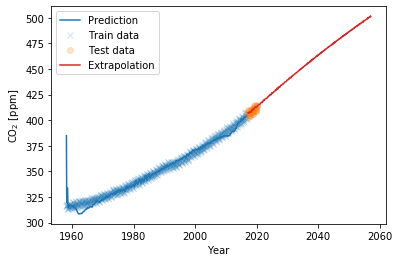

In [15]:
plt.plot(Xtrain.cpu().numpy()*xscale+xshift,Ytrain_pred*yscale+yshift,color='C0',label='Prediction')
plt.plot(Xtrain_np*xscale+xshift,Ytrain_np*yscale+yshift,'x',color='C0',alpha=0.2,label='Train data')
plt.plot(Xtest_np*xscale+xshift,Ytest_np*yscale+yshift,'o',color='C1',alpha=0.2,label='Test data')
plt.plot(Xpred.cpu().numpy()*xscale+xshift,Ypred*yscale+yshift,color='C3',label='Extrapolation')

plt.legend()
plt.xlabel(r'Year')
plt.ylabel(r'CO$_2$ [ppm]')
plt.show()


## Original PyTorch model

In [27]:
import torch.nn as nn


#############
# 1st way to define model
#############
# class NN(nn.Module):
#     def __init__(self):
#         super(NN, self).__init__()
#         self.linear1=nn.Linear(1,100)
#         self.linear2=nn.Linear(100,1)
#     
#     def forward(self,x):
#         x=nn.ReLU(self.linear1(x))
#         x=self.linear2(x)
#         return x
#                    
# model = NN

#############
# 2nd way to define model
#############
# model = torch.nn.Sequential(
#     nn.LSTM(1,100),
#     nn.ReLU(),
#     nn.Linear(100,1)
# )

import random

class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, future=0, y=None):
        outputs = []
        # reset the state of LSTM
        # the state is kept till the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            
            outputs += [output]
        for i in range(future):
            if y is not None and random.random() > 0.5:
                output = y[:, [i]]  # teacher forcing
            h_t, c_t = self.lstm(output, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [28]:
model = NN(1, 30, 1)

model.to(device)

criterion=nn.MSELoss()

# Change optimizer and hyperparameters
optimizer=torch.optim.SGD(model.parameters(),lr=1e-3,momentum=0.9,weight_decay=0)

NUM_EPOCHS=10000

for i in range(NUM_EPOCHS):
    optimizer.zero_grad()
    pred=model(Xtrain)
    loss=criterion(pred,Ytrain)
    loss.backward()
    optimizer.step()
    if (i+1)%(NUM_EPOCHS // 10)==0:
        with torch.no_grad():
            test_loss=criterion(model(Xtest),Ytest)
        print(f'{i+1}: {loss.item()}   {test_loss.item()}')


1000: 0.015286424197256565   0.20784644782543182
2000: 0.011138261295855045   0.12877778708934784
3000: 0.009960903786122799   0.0957351103425026
4000: 0.009460054337978363   0.07934834808111191
5000: 0.009148398414254189   0.0699133649468422
6000: 0.008914933539927006   0.06370226293802261
7000: 0.008727611973881721   0.059147804975509644
8000: 0.008572547696530819   0.055536188185214996
9000: 0.008441426791250706   0.05251798778772354
10000: 0.008328569121658802   0.04991022124886513


Plot the prediction and extrapolation for analysis

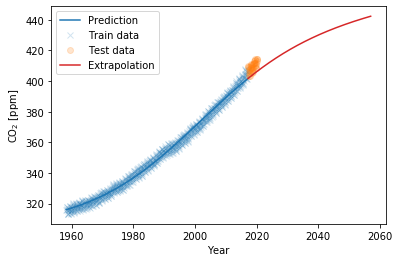

In [29]:
Xpred=torch.FloatTensor(Xpred_np).to(device)

with torch.no_grad():
    pred=model(Xtrain)
    predf=model(Xpred)
    
plt.plot(Xtrain.cpu().numpy()*xscale+xshift,pred.cpu().numpy()*yscale+yshift,color='C0',label='Prediction')
plt.plot(Xtrain_np*xscale+xshift,Ytrain_np*yscale+yshift,'x',color='C0',alpha=0.2,label='Train data')
plt.plot(Xtest_np*xscale+xshift,Ytest_np*yscale+yshift,'o',color='C1',alpha=0.2,label='Test data')
plt.plot(Xpred.cpu().numpy()*xscale+xshift,predf.cpu().numpy()*yscale+yshift,color='C3',label='Extrapolation')

plt.legend()
plt.xlabel(r'Year')
plt.ylabel(r'CO$_2$ [ppm]')
plt.show()

# Question:
**How is your model performing, is the behaviour expected?** 

*answer:*

- 2 Layer DNN ( Deep Neural Network with 2 hidden layers)
  - The 2 hidden layer DNN seems to be capturing the trend reasonably well than the other approaches we tried.

- Echo State Network (ESN)
  - Although this architecture is suitable for catching patterns in time-series data, the model was not able to do that.


- Recurrent Neural Network (RNN):
  - The RNN performs even worse than the ESN because it doesn't catch the trend of the data.

**Do you trust the extrapolation why/why not?** 

*answer:*

- DNN: The extrapolation on an avergage tends to capture the trend quite well but, obvioulsy not the seasonality.
- ESN: The extrapolation at least seems to catch the trend of the data, but obviously not the seasonality.
- RNN: The extrapolation is obviously wrong because it deviates even for the test set.

**How would you change the architecture or dataset to improve the extrapolation?**

*answer:*

Since this is time-series data, these are some proposal changes that might improve the extrapolation:
- Remove the "trend" of the data so that we get "fluctations" around a constant value.
- If that constant value is not 0, remove the "bias".
- Standardize data by divinding each data point with the standard deviation.

As a result we would get more-regular dataset that we assume would be suitable to be solved by ESN.
Additionally, better optimization techniques (e.g. differential evolution [1]) would definitiely improve model's performance.

[1] Otte, Sebastian, et al. "Optimizing recurrent reservoirs with neuro-evolution." <i>Neurocomputing</i> 192 (2016): 128-138.